In [13]:
# module scikit-learn spécialisé dans l'analyse de graphe
!pip install scikit-network
!pip install pyvis

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Import des packages nécessaires au clustering :

In [1]:
# permet de manipuler des matrices creuses, beaucoup plus efficace en complexité
from scipy import sparse

import numpy as np

import random

#le package de scikit-network spécialisé dans le clustering de graphes
import sknetwork.clustering

# méthode permettant de créer un graphe "visuel" à partir d'une matrice d'adjacence
from sknetwork.visualization import svg_graph

# méthode permettant d'afficher les graphes obtenus avec svg_graph
from IPython.display import SVG

# module permettant d'afficher des graphes interactifs
from pyvis.network import Network

# package nécessaire à l'ouverture des connections déterminées auparavant
import json

### Import des followings d'utilisateurs de Twitter sous la forme d'un dictionnaire

In [73]:
with open('dictionnaire_following.json', 'r') as fp:
    dictionnaire = json.load(fp)

### Toutes les fonctions permettant de créer le graphe (liste d'adjacence et matrice d'adjacence) à partir de la requête obtenue

In [72]:
def get_liste_voisins(dictionnaire) :
    '''
    Renvoie la liste des voisins de chaque noeud
    -------------
    Entrée : dictionnaire : dict : le dictionnaire issu de la requête
    -------------
    Sortie : int list list : pour chaque id (première dimension) la liste des ids de tous ses voisins
    
    '''
    res = []
    keys = dictionnaire.keys()
    
    # on parcourt les utilisateurs considérés
    for key in keys :
        
        # on va append res_key à res
        # res_key : la liste des following de l'utilisateur
        res_key = []
        
        # la liste de tous les following de l'utilisateur
        following = dictionnaire[key]
        
        # on parcourt les following de l'utilisateur
        for id_following in following :
            
            # parmi tous les following de l'utilisateur, il y en a beaucoup qui ne vont
            # pas apparaître dans le dictionnaire, mais seul ceux-ci nous intéressent
            if id_following in keys :
                res_key.append(int(id_following))
                
        res.append(res_key)
        
    return res


def get_liste_adjacence(dictionnaire) :
    '''
    Renvoie la liste d'adjacence du graphe obtenu à partir de la requête
    -------------
    Entrée : dictionnaire : dict : le dictionnaire issu de la requête
    -------------
    Sortie : int*int list : la liste d'adjacence avec les ids (int) des utilisateurs
    '''
    liste_voisins = dict2liste_voisins(dictionnaire)
    
    keys = list(dictionnaire.keys())
    
    res = []
    for i,voisins in enumerate(liste_voisins) :
        for voisin in voisins :
            res.append((int(keys[i]),voisin))
    
    return res


def get_numero (dictionnaire) :
    '''
    Cette fonction va permettre d'assigner à chaque id un indice utilisable
    comme indexation pour un tableau numpy
    -------------
    Entrée : dictionnaire : dict : le dictionnaire issu de la requête
    -------------
    Sortie : dict : dictionnaire où les clés sont les ids et renvoie à un entier
    '''
    keys = list(dictionnaire.keys())
    res = {}
    for i,key in enumerate(keys) : 
        res[key] = i
    return res


def liste_adjacence2matrice_adjacence(dictionnaire,liste_adjacence) :
    '''
    Renvoie la matrice d'adjacence du graphe
    -------------
    Entrée : 
        dictionnaire : dict : le dictionnaire issu de la requête
        liste_adjacence : int*int list : la liste d'adjacence avec les ids (int) des utilisateurs
    -------------
    Sortie : scipy sparse matrix (2) : matrice d'adjacence (creuse)
    '''
    numero = get_numero(dictionnaire)
    
    n = len(dictionnaire)
    res = np.zeros((n,n))
    
    for (i,j) in liste_adjacence :
        res[numero[str(i)],numero[str(j)]] = 1
    
    return sparse.csr_matrix(res)

In [89]:
liste_adjacence = get_liste_adjacence(dictionnaire_profils)
adjacence = liste_adjacence2matrice_adjacence(dictionnaire,liste_adjacence)
noeuds = [int(key) for key in dictionnaire.keys()]

### On crée deux fonctions permettant d'affecter des couleurs aléatoirement suivant les labels
scikit-network permet de faire cela, mais pas pyvis

In [79]:
def random_color () :
    '''
    Entrée : None
    ----------------------
    
    Sortie : str : code HEX d'une couleur choisie aléatoirement
    
    '''
    return ("#%06x" % random.randint(0, 0xFFFFFF))

In [80]:
def random_color_label(labels) :
    '''
    Entrée : labels : int list : la liste des labels des noeuds (des entiers)
    ----------------------------
    
    Sortie : str list : couleur aléatoire pour chaque label
    '''
    
    # label est une liste d'entier naturel
    nombre_label = max(labels)+1
    
    colors = [random_color() for i in range(nombre_label)]
    
    return [colors[label] for label in labels]

### Visualisation du graphe avec scikit-network :

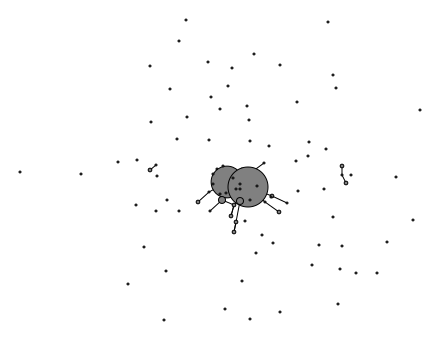

In [70]:
# Pour afficher le graphe avec scikit-network, la matrice d'adjacence doit nécessairement être une
# sparse matrix de scipy
image = svg_graph(adjacence,node_size=9.,display_node_weight=True)
SVG(image)

### Visualisation du graphe avec pyvis

In [33]:
#liste_adjacence = adjacence2liste_adjacence(adjacence)
graphe = Network(notebook=True)
graphe.add_nodes(list(dictionnaire_profils.keys()))
graphe.add_edges(liste_adjacence)
graphe.show('exemple-pyvis.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


# 1.   L'algorithme de Louvain

## 1.1 Présentation

L'algorithme de Louvain est un algorithme itératif de clustering de graphe.

Le but de l'algorithme est de choisir le partitionnement de graphe qui maximise une certaine fonction de gain Q appelée modularité.

Cet algorithme est composé de deux phases.

(1) Dans la première phase, on assigne une communauté à chaque noeud du graphe. Puis, on parcourt chaque noeud et on le met dans la communauté qui augmente le plus la fonction de gain Q. La première phase s'arrête lorsqu'aucun mouvement d'un individu ne permet d'augmenter Q.

(2) Dans la deuxième phase, on construit un nouveau réseau dans lequel les noeuds correspondent aux communautés construites précédemment.

Une fois ceci fait, on réitère ces deux phases sur ce nouveau réseau, puis on arrête l'algorithme lorsqu'on ne peut plus augmenter Q.

$ \\ $

Pour plus d'information, veuillez lire le document suivant : https://arxiv.org/pdf/0803.0476v2.pdf

## 1.2 Création du clustering

In [76]:
from sknetwork.clustering import Louvain

adjacence_louvain = adjacence.copy()

louvain = Louvain(random_state=0)

# louvain.fit_transform fit la matrice d'adjacence avec la méthode de Louvain et renvoie
# les labels de clustering correspondants
labels_louvain = louvain.fit_transform(adjacence_louvain)

print(labels_louvain)

[ 0 12  1 52 51 50  0 49  6  6 48 47 53  0 46  0 44 43 42 41  0  7  7 40
 39  1 45  0  4 55 63  2  5 56  0 70  1 69 68 67  0 66 65  1 71 64 62  1
 61 60 59 58 57 38 37 36  0  2  8  2 22  2 17 16  3  2 15  0  1 14  4  8
 18  1 11 10  9  1  1 13 19 35 21  0 20 23  3 24  1 25 26  0 27  1 28 29
 30  1  0 31 32 33 34  0  0  0  0  3  5 54 72]


## 1.3 Affichage des clusters obtenus

### 1.3.1 Affichage avec scikit-network

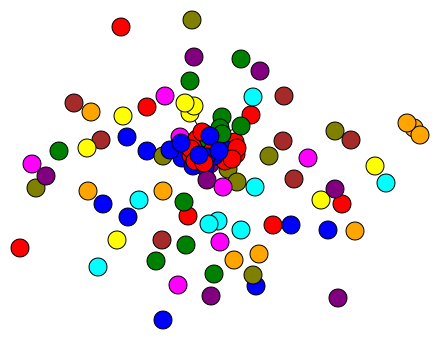

In [84]:
image_louvain = svg_graph(adjacence_louvain,labels=labels_louvain,node_size=9.,display_node_weight=False)
SVG(image_louvain)

### 1.3.2 Affichage avec pyvis

In [90]:
couleurs_louvain = random_color_label(labels_louvain)

# les labels utilisé avec pyvis sont des chaînes de caractères
labels_louvain_str = [str(label) for label in labels_louvain]

net = Network(notebook=True)

net.add_nodes(noeuds, 
              label=labels_louvain_str,
              color=couleurs_louvain)

net.add_edges(liste_adjacence)

net.show('louvain.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


# 2. Clustering spectral

## 2.1 Présentation

L'algorithme de Clustering spectral est un algorithme de clustering de graphe utilisant la méthode des k-means.

Cette méthode des k-means a été vue en cours, mais ne peut pas s'appliquer directement à un graphe, qui, contrairement à un nuage de points par exemple, n'a pas de portée géométrique.

(1) Pour appliquer la méthode des k-means, on considère alors la matrice de Laplace. Pour rappel, cette matrice est définie par :
$$ L = D-A $$
où $A$ est la matrice d'adjacence, et $D$ est une matrice diagonale où chaque élément de la diagonale est la somme des éléments de la ligne de $A$ correspondante

(2) Une fois cette matrice calculée, on détermine les vecteurs propres de cette matrice. On sélectionne alors les k vecteurs propres (où k est le nombre de clusters voulus) correspondants aux k premières valeurs propres (rangées dans par ordre croissant).

(3) Enfin, il suffit d'appliquer l'algorithme des k-means à ces k vecteurs propres.


On remarquera que dans cet algorithme, contrairement aux deux autres algorithmes présentés, on n'a pas besoin de spécifier le nombre de clusters voulus.


$ \\ $

Pour plus d'information, veuillez vous référer à la page Wikipédia correspondante : https://en.wikipedia.org/wiki/Spectral_clustering

## 2.2 Création du clustering

In [91]:
# la méthode KMeans correspond bien à du clustering spectral, et non à le méthode des k-means,
# qui n'a pas de sens pour un graphe
from sknetwork.clustering import KMeans

adjacence_spectral = adjacence.copy()

kmeans = KMeans(n_clusters=4)

# kmeans.fit_transform fit la matrice d'adjacence avec la méthode de clustering spectral
# et renvoie les labels de clustering correspondants
labels_spectral = kmeans.fit_transform(adjacence_spectral)

print(labels_spectral)

[1 0 2 0 0 0 1 0 2 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 2 0 1 1 0 0 0 3 0 1 0 2
 0 0 0 1 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 2 0 0 0 0 2
 0 0 0 2 3 0 0 0 0 1 0 0 0 0 2 0 0 1 0 2 0 0 0 2 3 0 0 0 0 1 1 1 1 0 0 0 0]


## 2.3 Affichage des clusters obtenus

### 2.3.1 Affichage avec scikit-network

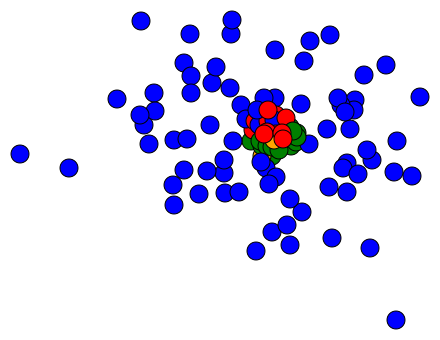

In [92]:
image_spectral = svg_graph(adjacence_spectral,labels=labels_spectral,node_size=9.,display_node_weight=False)
SVG(image_spectral)

### 1.3.2 Affichage avec pyvis

In [93]:
couleurs_spectral = random_color_label(labels_spectral)

# les labels utilisé avec pyvis sont des chaînes de caractères
labels_spectral_str = [str(label) for label in labels_spectral]

net = Network(notebook=True)

net.add_nodes(noeuds, 
              label=labels_spectral_str,
              color=couleurs_spectral)

net.add_edges(liste_adjacence)

net.show('spectral.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


# 3. Clustering par propagation d'étiquette ("label propagation")

## 3.1 Présentation

L'algorithme de Clustering par "label propagation" est un algorithme itératif de clustering de graphe.

Cet algorithme consiste à assigner une "étiquette" aux différents noeuds, puis, pour chaque noeud, à changer les différentes "étiquettes" en étudiant celles du voisinage de ce noeud.

Vous trouverez ci-dessous les étapes de cet algorithme. Par la suite, on notera $ t $ l'itération de l'algorithme et $C_x(t) $ l'étiquette du noeud $ x $ à l'itération $ t $.

(1) On initialise tout d'abord les labels de chaque noeuds en leur donnant une valeur différente : $$ \forall x, C_x(0) = x .$$

(2) On fixe $ t = 1$

(3) On considère ensuite un ordre aléatoire $ X $ des noeuds du graphe.

(4) Pour chaque noeud $ x $ dans l'ordre défini par $ X $, on met à jour le label du noeud $ x $. $ C_x(t) $ correspond alors au label le plus fréquent dans les voisins de $ x $. En cas d'égalité entre plusieurs labels, on en choisit un aléatoirement.

(5) Enfin, si chaque noeud possède une étiquette que le nombre maximum de ses voisins possède, alors l'algorithme s'arrête. Sinon, $ t = t+1$ et on retourne en (3).

$ \\ $

Pour plus d'information, veuillez consulter le document suivant : https://arxiv.org/pdf/0709.2938.pdf

## 3.2 Création du clustering

In [94]:
from sknetwork.clustering import PropagationClustering

propagation = PropagationClustering(n_iter=-1)

adjacence_propagation = adjacence.copy()

# propagation.fit_transform fit la matrice d'adjacence avec la méthode de propagation
# et renvoie les labels de clustering correspondants
labels_propagation = propagation.fit_transform(adjacence_propagation)

print(labels_propagation)

[14  0 57  1  2  3 57  4 57 57  5  6  7 57  8  9 10 11 12 13 14 57 15 16
 17 57 18 14 57 19 20 14 69 21 14 22 57 23 24 25 14 26 27 57 28 29 30 57
 31 32 33 34 35 36 37 38 57 14 44 14 39 14 40 41 68 14 42 14 57 43 57 44
 45 57 46 47 48 57 57 49 50 51 52 57 53 54 55 56 57 58 59 57 60 57 61 62
 63 57 57 64 65 66 67 57 14 57 14 68 69 70 71]


## 3.3 Affichage des clusters obtenus

### 3.3.1 Affichage avec scikit-network

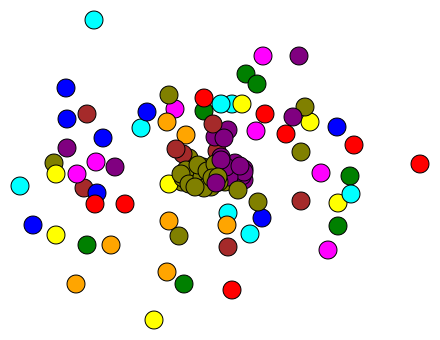

In [95]:
image_propagation = svg_graph(adjacence_propagation,labels=labels_propagation,node_size=9.,display_node_weight=False)
SVG(image_propagation)

### 3.3.2 Affichage avec pyvis

In [97]:
couleurs_propagation = random_color_label(labels_propagation)

# les labels utilisé avec pyvis sont des chaînes de caractères
labels_propagation_str = [str(label) for label in labels_spectral]

net = Network(notebook=True)

net.add_nodes(noeuds, 
              label=labels_propagation_str,
              color=couleurs_propagation)

net.add_edges(liste_adjacence)

net.show('propagation.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
